In [1]:
%matplotlib inline

from pyspark.sql import SparkSession
from pyspark import SparkConf, StorageLevel
import pyspark.sql.functions as F
from cleantext import clean
from pyspark.find_spark_home import _find_spark_home
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
print(_find_spark_home())


C:\Users\workl\anaconda3\envs\BigData\Lib\site-packages\pyspark


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\workl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
conf = SparkConf().setMaster('local[*]') \
        .set("spark.local.dir", "D:/BigData_UkraineTwitter/tmp/spark-temp")
spark = SparkSession.builder.appName("UkraineStuff").config(conf=conf).getOrCreate()
sc = spark.sparkContext

In [ ]:
df = spark.read.options(header=True, 
                        escape='"', 
                        multiline=True,
                        ).csv('hdfs://localhost:9000/ukraine_tweets/extracted/')

min_df = df.drop('_c0', 'userid', 'username', 'followers', 'acctdesc', 'location', 'following', 'totaltweets', 'usercreatedts', 'tweetid', 'tweetcreatedts', 'retweetcount', 'coordinates', 'favorite_count', 'extractedts')

min_df.repartition(256).persist(StorageLevel.MEMORY_AND_DISK).write.mode('overwrite').parquet('hdfs://localhost:9000/ukraine_tweets/results')

In [13]:
min_df = spark.read.parquet('hdfs://localhost:9000/ukraine_tweets/results')

df_index = min_df.select("*").withColumn("id", F.monotonically_increasing_id())
column_list = df_index.columns
column_list.remove('id')

df_index = df_index.select('id', *column_list)

rows_to_delete = df_index.filter(df_index['language'] != 'en')

df_index = df_index.join(rows_to_delete, on=['id'], how='left_anti')

df_index.repartition(256, 'id').persist(StorageLevel.MEMORY_AND_DISK).write.mode('overwrite').parquet('hdfs://localhost:9000/ukraine_tweets/english_removed')

In [44]:
df_index = spark.read.parquet('hdfs://localhost:9000/ukraine_tweets/english_removed')

@F.udf
def clean_emojis_and_urls(s):
    if s is not None:
        return clean(s, no_emoji=True, no_urls=True, no_line_breaks=True, no_punct=True, no_currency_symbols=True, replace_with_url="", replace_with_currency_symbol="")

df_index = df_index.withColumn('text', F.regexp_replace('text', r'[#][a-zA-Z0-9_#]*', ''))
df_index = df_index.withColumn('text', F.regexp_replace('text', r'[@]', ''))
df_index = df_index.withColumn('text', F.regexp_replace('text', r"['’‘]s", ''))
df_index = df_index.withColumn('text', clean_emojis_and_urls('text'))
df_index = df_index.withColumn('text', F.regexp_replace('text', r'<url>', ''))

df_index.repartition(256, 'id').persist(StorageLevel.MEMORY_AND_DISK).write.mode('overwrite').parquet('hdfs://localhost:9000/ukraine_tweets/text_cleaned')

In [46]:
df_index = spark.read.parquet('hdfs://localhost:9000/ukraine_tweets/text_cleaned')

rows_to_delete = df_index.filter(df_index['text'] == '')

df_index = df_index.join(rows_to_delete, on=['id'], how='left_anti')

df_index.repartition(256, 'id').persist(StorageLevel.MEMORY_AND_DISK).write.mode('overwrite').parquet('hdfs://localhost:9000/ukraine_tweets/empty_text_removed')

In [24]:
df_index = spark.read.parquet('hdfs://localhost:9000/ukraine_tweets/empty_text_removed')

clean_df = df_index.withColumn("words", F.explode(F.split(F.trim("text"), " "))).groupBy("words").count()

# Remove stopwords
stop_words = set(stopwords.words('english'))
rows_to_delete = clean_df.filter(clean_df.words.isin(stop_words))
clean_df = clean_df.join(rows_to_delete, on=['words'], how='left_anti')

clean_df.persist(StorageLevel.MEMORY_AND_DISK).write.mode('overwrite').parquet('hdfs://localhost:9000/ukraine_tweets/final_count')

In [25]:
clean_df = spark.read.parquet('hdfs://localhost:9000/ukraine_tweets/final_count')
words = clean_df.rdd.map(lambda x: (x[0], x[1])).collectAsMap()

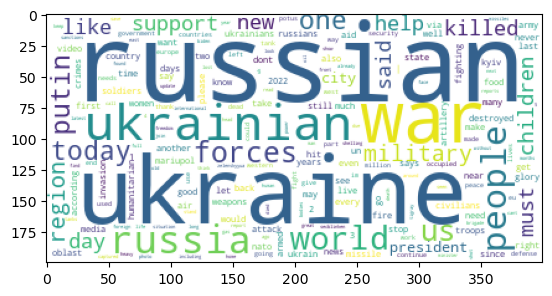

In [26]:
wordcloud = WordCloud(background_color="white")
plt.imshow(wordcloud.generate_from_frequencies(words))
plt.show()